# Ensembling Models

The following is a brief demonstration of the ensemble models in Darts. Starting from the examples provided in the [Quickstart Notebook](https://unit8co.github.io/darts/quickstart/00-quickstart.html), some advanced features and subtilities will be detailed.

The following topics are covered in this notebook :
* [Basics & references](#Basics-&-references)
* [Naive Ensembling](#naive-ensembling)
    * [Deterministic](#naive-ensembling)
    * [Covariates & multivariate series](#using-covariates--predicting-multivariate-series)
    * [Probabilistic](#probabilistic-naive-ensembling)
* [Learned Ensembling](#learned-ensembling)
    * [Deterministic](#learned-ensembling)
    * [Probabilistic](#probabilistic-regression-ensemble)
    * [Bootstraping](#bootstrapping-regression-ensemble)
* [Pre-trained Ensembling](#pre-trained-ensembling)

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

from darts.models import (
    ExponentialSmoothing,
    KalmanForecaster,
    LinearRegressionModel,
    NaiveDrift,
    NaiveEnsembleModel,
    NaiveSeasonal,
    RandomForest,
    RegressionEnsembleModel,
    TCNModel,
)
from darts.metrics import mape
from darts.datasets import AirPassengersDataset
from darts.utils.timeseries_generation import (
    datetime_attribute_timeseries as dt_attr,
)
from darts.dataprocessing.transformers import Scaler

import warnings

warnings.filterwarnings("ignore")

import logging

logging.disable(logging.CRITICAL)

## Basics & references

Ensembling combines the forecasts of several "weak" models to obtain a more robust and accurate model.

All of Darts' ensembling models rely on the **stacking technique** ([reference](https://machinelearningmastery.com/essence-of-stacking-ensembles-for-machine-learning/)). They provide the same functionalities as the other forecasting models. Depending on the ensembled models, they can:

* levarage covariates
* be trained on multiple-series
* predict multivariate targets
* generate probabilistic forecasts
* and more...

<Axes: xlabel='Month'>

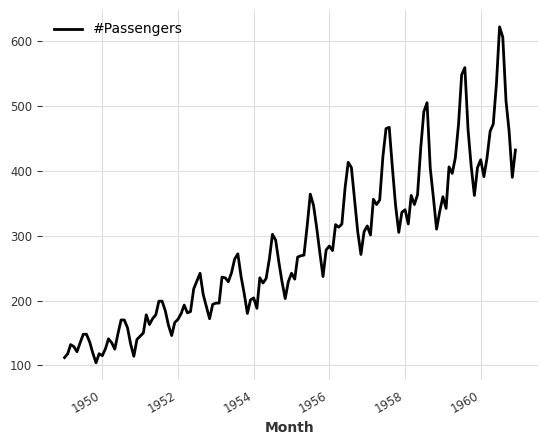

In [3]:
# using the AirPassenger dataset, directly available in darts
ts_air = AirPassengersDataset().load()
ts_air.plot()

## Naive Ensembling

Naive ensembling simply takes the average (mean) of the forecasts generated by the ensembled forecasting models. Darts' `NaiveEnsembleModel` accepts both local and global forecasting models (as well as combination of the two, with some additional limitations).

NaiveEnsemble (naive) MAPE: 11.87818


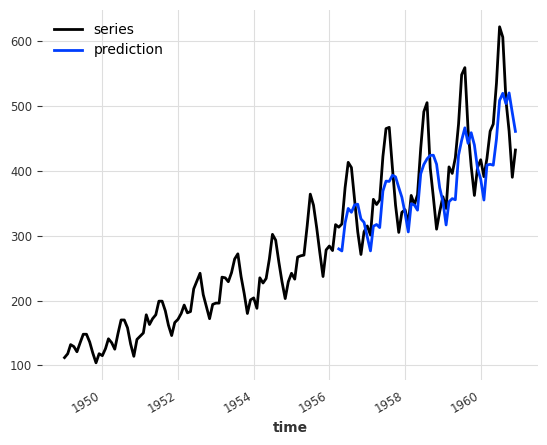

In [4]:
naive_ensemble = NaiveEnsembleModel(
    forecasting_models=[NaiveSeasonal(K=12), NaiveDrift()]
)

backtest = naive_ensemble.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)

ts_air.plot(label="series")
backtest.plot(label="prediction")
print("NaiveEnsemble (naive) MAPE:", round(mape(backtest, ts_air), 5))

**Note**: after looking at the each model's MAPE, one would notice that `NaiveSeasonal` is actually performing better on its own than ensembled with `NaiveDrift`. Checking the performance of the single models is in general a good practice before defining an ensemble. 

Before creating the new `NaiveEnsemble`, we will screen models to identify which ones would do well together. The candidates are : 
- `LinearRegressionModel` : classic and simple model
- `ExponentialSmoothing` : moving window model
- `FalmanForecaster` : a filter-based model
- `RandomForest` : decision trees model

In [5]:
candidates_models = {
    "LinearRegression": (LinearRegressionModel, {"lags": 12}),
    "ExponentialSmoothing": (ExponentialSmoothing, {}),
    "KalmanForecaster": (KalmanForecaster, {"dim_x": 12}),
    "RandomForest": (RandomForest, {"lags": 12, "random_state": 0}),
}

backtest_models = []

for model_name, (model_cls, model_kwargs) in candidates_models.items():
    model = model_cls(**model_kwargs)
    backtest_models.append(
        model.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)
    )
    print(f"{model_name} MAPE: {round(mape(backtest_models[-1], ts_air), 5)}")

LinearRegression MAPE: 4.64008
ExponentialSmoothing MAPE: 4.44874
KalmanForecaster MAPE: 4.5539
RandomForest MAPE: 8.02264


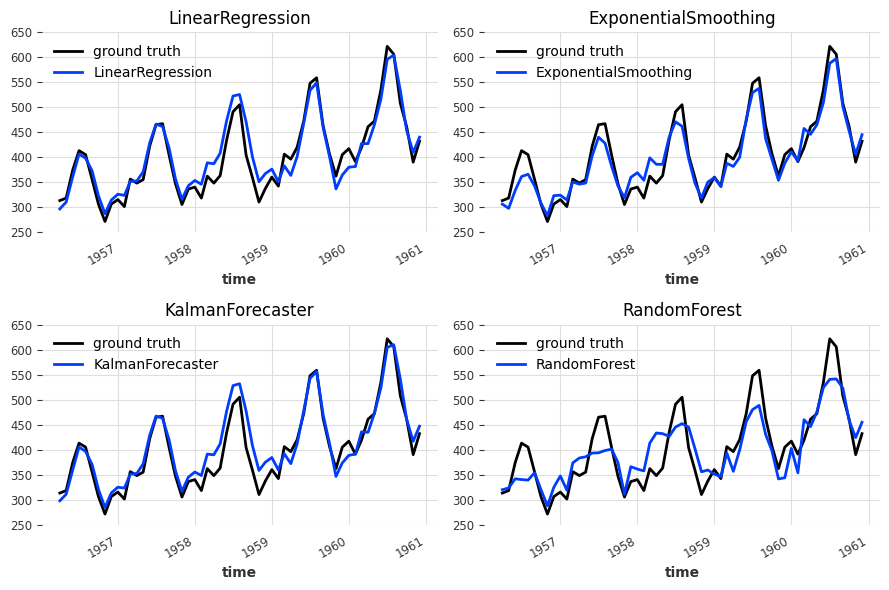

In [6]:
fix, axes = plt.subplots(2, 2, figsize=(9, 6))
for ax, backtest, model_name in zip(
    axes.flatten(),
    backtest_models,
    list(candidates_models.keys()),
):
    ts_air[-len(backtest) :].plot(ax=ax, label="ground truth")
    backtest.plot(ax=ax, label=model_name)

    ax.set_title(model_name)
    ax.set_ylim([250, 650])
plt.tight_layout()

The historical forecasts obtained with the `LinearRegressionModel` and `KalmanForecaster` look quite similar whereas `ExponentialSmoothing` tends to understimate the true values and `RandomForest` is failing to capture the peaks. To benefits from the ensemble, we will favor diversity and continue with the `LinearRegressionModel` and `ExponentialSmoothing`.

NaiveEnsemble (v2) MAPE: 4.04297


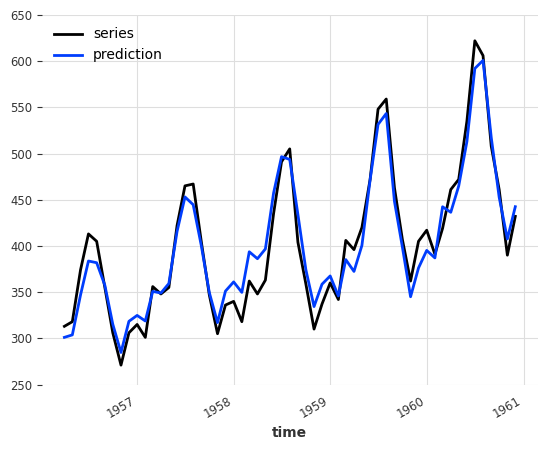

In [7]:
ensemble = NaiveEnsembleModel(
    forecasting_models=[LinearRegressionModel(lags=12), ExponentialSmoothing()]
)

backtest = ensemble.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)

ts_air[-len(backtest) :].plot(label="series")
backtest.plot(label="prediction")
plt.ylim([250, 650])
print("NaiveEnsemble (v2) MAPE:", round(mape(backtest, ts_air), 5))

Compared to the individual model MAPE score, 4.64008 for the `LinearRegressionModel` and 4.44874 for the `ExponentialSmoothing`, the ensembling improved the accuracy to 4.04297!


### Using covariates & predicting multivariate series

Depending on the forecasting models used, the `EnsembleModel` can of course also leverage covariates or forecast multivariates series! The covariates will be passed only to the forecasting models supporting them.

In the example below, the `ExponentialSmoothing` model does not support any covariates whereas the `LinearRegressionModel` model supports `future_covariates`.

NaiveEnsemble (w/ future covariates) MAPE: 4.07502


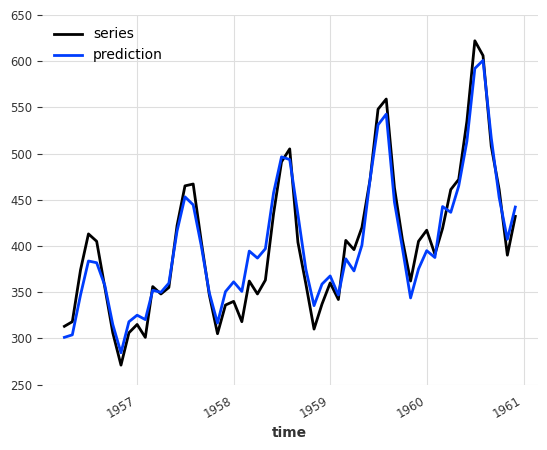

In [8]:
ensemble = NaiveEnsembleModel(
    [LinearRegressionModel(lags=12, lags_future_covariates=[0]), ExponentialSmoothing()]
)

# encoding the months as integer, normalised
future_cov = dt_attr(ts_air.time_index, "month", add_length=12) / 12
backtest = ensemble.historical_forecasts(
    ts_air, future_covariates=future_cov, start=0.6, forecast_horizon=3
)

ts_air[-len(backtest) :].plot(label="series")
backtest.plot(label="prediction")
plt.ylim([250, 650])
print("NaiveEnsemble (w/ future covariates) MAPE:", round(mape(backtest, ts_air), 5))





### Probabilistic naive ensembling

Combining models supporting probabilistic forecasts results in a probabilistic `NaiveEnsembleModel`! We can easily tweak the models used above to make them probabilistic and obtain confidence interval in ours forecasts:

<Axes: xlabel='time'>

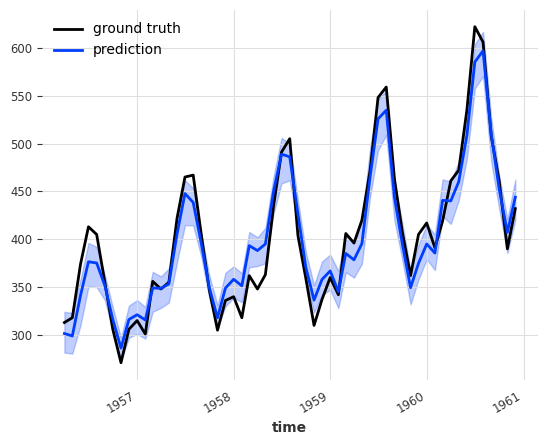

In [9]:
ensemble_probabilistic = NaiveEnsembleModel(
    forecasting_models=[
        LinearRegressionModel(
            lags=12,
            likelihood="quantile",
            quantiles=[0.05, 0.5, 0.95],
        ),
        ExponentialSmoothing(),
    ]
)

# must pass num_samples > 1 to obtain a probabilistic forecasts
backtest = ensemble_probabilistic.historical_forecasts(
    ts_air, start=0.6, forecast_horizon=3, num_samples=100
)

ts_air[-len(backtest) :].plot(label="ground truth")
backtest.plot(label="prediction")

## Learned Ensembling

Ensembling can also be considered as a supervised regression problem: given a set of forecasts (features), find a model that combines them in order to minimise errors on the target. This is what the `RegressionEnsembleModel` does. The main three parameters are:

* `forecasting_models` is a list of forecasting models whose predictions we want to ensemble.
* `regression_train_n_points` is the number of time steps to use for fitting the "ensemble regression" model (i.e., the inner model that combines the forecasts).
* `regression_model` is, optionally, a sklearn-compatible regression model or a Darts `RegressionModel` to be used for the ensemble regression. If not specified, Darts' `LinearRegressionModel` is used. Using a sklearn model is easy out-of-the-box, but using one of Darts' regression models allows to potentially take arbitrary lags of the individual forecasts as inputs of the regression model.

Once these elements are in place, a `RegressionEnsembleModel` can be used like a regular forecasting model:

RegressionEnsemble (naive) MAPE: 4.85142


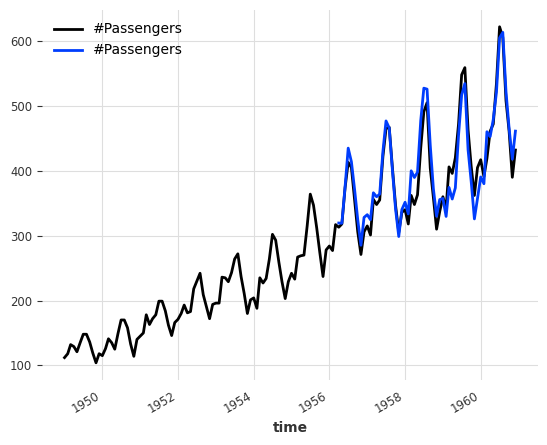

In [10]:
ensemble_model = RegressionEnsembleModel(
    forecasting_models=[NaiveSeasonal(K=12), NaiveDrift()],
    regression_train_n_points=12,
)

backtest = ensemble_model.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)

ts_air.plot()
backtest.plot()

print("RegressionEnsemble (naive) MAPE:", round(mape(backtest, ts_air), 5))

Compared to the MAPE of 11.87818 obtained at the beginning of the [naive ensembling section](#Naive-ensembling), adding a `LinearRegressionModel` on top of the two naive models does improve the quality of the forecast.

Now, let's see if we can observe similar gain when the `RegressionEnsemble` forecasting models are not naive:

RegressionEnsemble (v2) MAPE: 4.63334


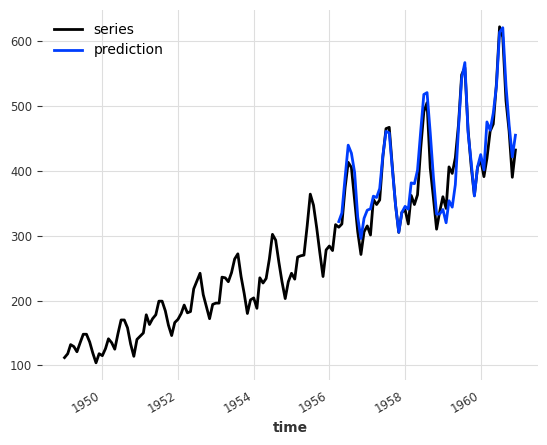

In [11]:
ensemble = RegressionEnsembleModel(
    forecasting_models=[LinearRegressionModel(lags=12), ExponentialSmoothing()],
    regression_train_n_points=12,
)

backtest = ensemble.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)

ts_air.plot(label="series")
backtest.plot(label="prediction")

print("RegressionEnsemble (v2) MAPE:", round(mape(backtest, ts_air), 5))

Interestingly, even if the MAPE improved compared to the `RegressionEnsemble` relying on naive models (MAPE: 4.85142), it does not outperform the `NaiveEnsemble` using similar forecasting models (MAPE: 4.04297). 

This performance gap is partially caused by the points set aside to train the ensembling `LinearRegression`; the two forecasting models (`LinearRegression` and `ExponentialSmoothing`) cannot access the latest values of the series, which contains a marked upward trend.

Out of curiosity, we can use the `Ridge` regression model from the sklearn library to ensemble the forecasts:

In [12]:
from sklearn.linear_model import Ridge

ensemble = RegressionEnsembleModel(
    forecasting_models=[LinearRegressionModel(lags=12), ExponentialSmoothing()],
    regression_train_n_points=12,
    regression_model=Ridge(),
)

backtest = ensemble.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)

print("RegressionEnsemble (Ridge) MAPE:", round(mape(backtest, ts_air), 5))

RegressionEnsemble (Ridge) MAPE: 6.46803


In this particuliar scenario, using a regression model with a regularization term deteriorated the forecasts but there might be other cases where it will improve them.

### Training using historical forecasts

When predicting a number of values greater than their `output_chunk_length`, `GlobalForecastingModels` rely on auto-regression (use their own output as input) to forecast values far in the future. However, the quality of the forecasts can considerably decrease as the predicted timestamp get further from the end of the observations. During `RegressionEnsemble`'s regression model training, the forecasting models generate forecasts for timestamps where the ground truth is actually known and available, making it possible to use `historical_forecasts` instead of `predict()`.

This can be activated with `train_using_historical_forecasts=True`.

Under the hood, the ensemble model will trigger historical forecasting for each model with `forecast_horizon=model.output_chunk_length`, `stride=model.output_chunk_length`, `last_points_only=False`, and `overlap_end=False` to predict the last `regression_train_n_points` points of the target series.

In [13]:
# replacing the ExponentialSmoothing (local) with RandomForest (global)
ensemble = RegressionEnsembleModel(
    forecasting_models=[
        LinearRegressionModel(lags=12),
        RandomForest(lags=12, random_state=0),
    ],
    regression_train_n_points=12,
    train_using_historical_forecasts=False,
)
backtest = ensemble.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)

ensemble_hist_fct = RegressionEnsembleModel(
    forecasting_models=[
        LinearRegressionModel(lags=12),
        RandomForest(lags=12, random_state=0),
    ],
    regression_train_n_points=12,
    train_using_historical_forecasts=True,
)
backtest_hist_fct = ensemble_hist_fct.historical_forecasts(
    ts_air, start=0.6, forecast_horizon=3
)

print("RegressionEnsemble (no hist_fct) MAPE:", round(mape(backtest, ts_air), 5))
print("RegressionEnsemble (hist_fct) MAPE:", round(mape(backtest_hist_fct, ts_air), 5))

RegressionEnsemble (no hist_fct) MAPE: 5.7016
RegressionEnsemble (hist_fct) MAPE: 5.12017


As expected, using historical forecasts with the forecasting models to the train the regression model produces better forecasts.

### Probabilistic regression ensemble

In order to be probabilistic, the `RegressionEnsembleModel`, must have a probabilistic ensembling regression model (see table in the README):

RegressionEnsemble (probabilistic) MAPE: 5.15071


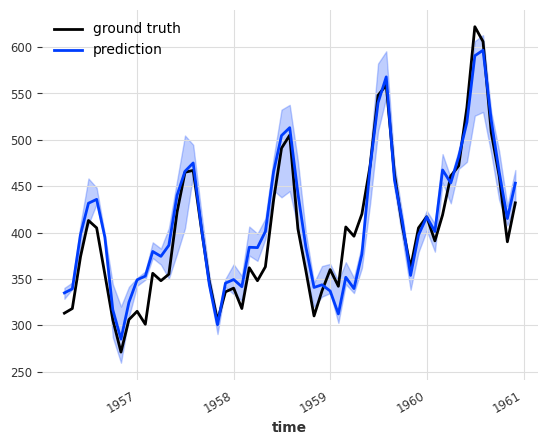

In [14]:
ensemble = RegressionEnsembleModel(
    forecasting_models=[LinearRegressionModel(lags=12), ExponentialSmoothing()],
    regression_train_n_points=12,
    regression_model=LinearRegressionModel(
        lags_future_covariates=[0], likelihood="quantile", quantiles=[0.05, 0.5, 0.95]
    ),
)

backtest = ensemble.historical_forecasts(
    ts_air, start=0.6, forecast_horizon=3, num_samples=100
)

ts_air[-len(backtest) :].plot(label="ground truth")
backtest.plot(label="prediction")

print("RegressionEnsemble (probabilistic) MAPE:", round(mape(backtest, ts_air), 5))

### Bootstrapping regression ensemble

When the forecasting models of a `RegressionEnsembleModel` are probabilistic, the samples dimension of their forecasts is reduced and used as covariates for the ensembling regression. Since the ensembling regression model is deterministic, the generated forecasts is deterministic as well.

RegressionEnsemble (bootstrap) MAPE: 5.10138


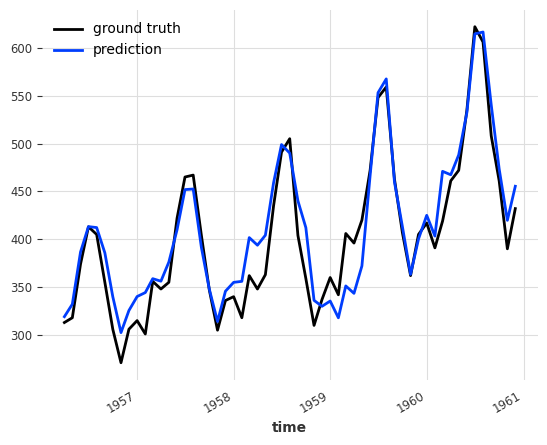

In [15]:
ensemble = RegressionEnsembleModel(
    forecasting_models=[
        LinearRegressionModel(
            lags=12, likelihood="quantile", quantiles=[0.05, 0.5, 0.95]
        ),
        ExponentialSmoothing(),
    ],
    regression_train_n_points=12,
    regression_train_num_samples=100,
    regression_train_samples_reduction="median",
)

backtest = ensemble.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)

ts_air[-len(backtest) :].plot(label="ground truth")
backtest.plot(label="prediction")

print("RegressionEnsemble (bootstrap) MAPE:", round(mape(backtest, ts_air), 5))

### Pre-trained Ensembling

As both `NaiveEnsembleModel` and `RegressionEnsembleModel` accept `GlobalForecastingModel` as forecasting models, they can be used to ensemble pre-trained deep learning and regression models. Note that this functionnality is only supported if all the ensembled forecasting models are instances from the `GlobalForecastingModel` class and are already trained when creating the ensemble.

**Disclaimer** : Be careful not to pre-train the models with data used during validation as this would introduce considerable bias.

**Note** : The parameters for the `TCNModel` is heavily inspired from the [TCNModel example notebook](https://unit8co.github.io/darts/examples/05-TCN-examples.html).

In [16]:
# holding out values for validation
train, val = ts_air.split_after(0.8)

# scaling the target
scaler = Scaler()
train = scaler.fit_transform(train)
val = scaler.transform(val)

# use the month as a covariate
month_series = dt_attr(ts_air.time_index, attribute="month", one_hot=True)
scaler_month = Scaler()
month_series = scaler_month.fit_transform(month_series)

# training a regular linear regression, without any covariates
linreg_model = LinearRegressionModel(lags=24)
linreg_model.fit(train)

# instanciating a TCN model with parameters optimized for the AirPassenger dataset
tcn_model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=500,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,
)
tcn_model.fit(train, past_covariates=month_series)

Training: 0it [00:00, ?it/s]

TCNModel(kernel_size=5, num_filters=3, num_layers=None, dilation_base=2, weight_norm=True, dropout=0.2, input_chunk_length=24, output_chunk_length=12, n_epochs=500, random_state=0)

As a sanity check, we will look at the forecast of the model taken individually:

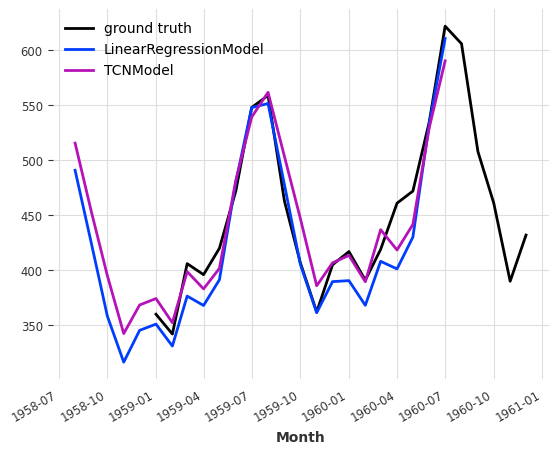

In [17]:
# individual model forecasts
pred_linreg = linreg_model.predict(24)
pred_tcn = tcn_model.predict(24, verbose=False)

# scaling them back
pred_linreg_rescaled = scaler.inverse_transform(pred_linreg)
pred_tcn_rescaled = scaler.inverse_transform(pred_tcn)

# plotting
ts_air[-24:].plot(label="ground truth")
pred_linreg_rescaled.plot(label="LinearRegressionModel")
pred_tcn_rescaled.plot(label="TCNModel")
plt.show()

Now that we have a good idea of the individual performance of each of these models, we can ensemble them. We must make sure to set `retrain_forecasting_models=False` or the ensemble will need to be fitted before being able to call `predict()`.

**Advice** : Use the `save()` method to export your model and keep a copy of your weights.

LinearRegression MAPE: 3.91311
TCNModel MAPE: 4.70491
NaiveEnsemble (pre-trained) MAPE: 3.82837
RegressionEnsemble (pre-trained) MAPE: 3.61749


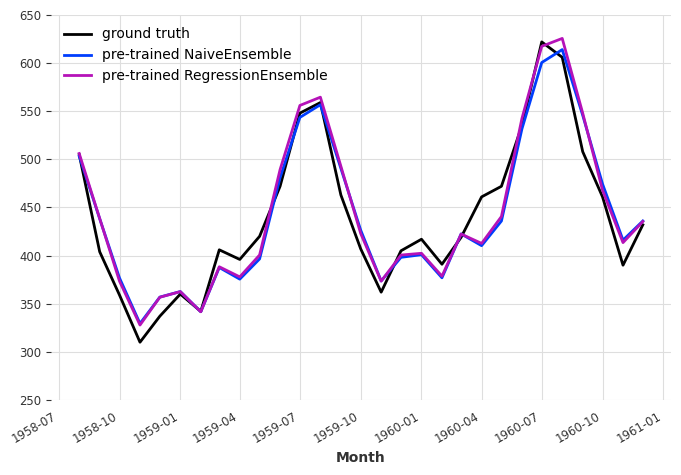

In [18]:
naive_ensemble = NaiveEnsembleModel(
    forecasting_models=[tcn_model, linreg_model], train_forecasting_models=False
)
# NaiveEnsemble initialized with pre-trained models can call predict() directly,
# the `series` argument must however be provided
pred_naive = naive_ensemble.predict(len(val), train)

pretrain_ensemble = RegressionEnsembleModel(
    forecasting_models=[tcn_model, linreg_model],
    regression_train_n_points=24,
    train_forecasting_models=False,
    train_using_historical_forecasts=False,
)
# RegressionEnsemble must train the ensemble model, even if the forecasting models are already trained
pretrain_ensemble.fit(train)
pred_ens = pretrain_ensemble.predict(len(val))

# scaling back the predictions
pred_naive_rescaled = scaler.inverse_transform(pred_naive)
pred_ens_rescaled = scaler.inverse_transform(pred_ens)

# plotting
plt.figure(figsize=(8, 5))
scaler.inverse_transform(val).plot(label="ground truth")
pred_naive_rescaled.plot(label="pre-trained NaiveEnsemble")
pred_ens_rescaled.plot(label="pre-trained RegressionEnsemble")
plt.ylim([250, 650])

# MAPE
print("LinearRegression MAPE:", round(mape(pred_linreg_rescaled, ts_air), 5))
print("TCNModel MAPE:", round(mape(pred_tcn_rescaled, ts_air), 5))
print("NaiveEnsemble (pre-trained) MAPE:", round(mape(pred_naive_rescaled, ts_air), 5))
print(
    "RegressionEnsemble (pre-trained) MAPE:", round(mape(pred_ens_rescaled, ts_air), 5)
)

## Conclusion

Ensembling pre-trained `LinearRegression` and `TCNModel` models allowed us to out-perform single models and training a linear regression on top of these two models forecasts further improved the MAPE score.

If the gains remain limited on this small dataset, ensembling is a powerful technique that can yield impressive results and was notably used by the winners of the 4th edition of the Makridakis Competition ([website](https://mofc.unic.ac.cy/history-of-competitions/), [github repository](https://github.com/Mcompetitions/)).